In [1]:
import datetime
import os
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

path_src = os.path.dirname(os.getcwd())
os.chdir(path_src)

In [2]:
base_results_dir = "results"
dataset_names = os.listdir(base_results_dir)

In [3]:
print(dataset_names)

['.ipynb_checkpoints', 'Arrhythmia', 'Breast_GSE70947', 'GenesPigmentacaoGencove-20220228', 'GenesPigmentacaoGencove-20220228-reduced', 'Leukemia_GSE28497', 'p53_Mutants']


In [4]:
def prepare_data(target_path, target_clf = "xgb", min_f = 2, max_f = 50):
    source_df = pd.read_csv(target_path)
    source_df

    baseline_f = source_df["features"].max()
    target_df = source_df[source_df["model"] == target_clf]
    target_df

    # Get aggregated stats
    agg_df_non_processed = (target_df.groupby(["experiment_id", "model", "fs_method", "run_id", "features"])["test_f1_macro"]
                        .agg(["mean"])
                        .groupby(["experiment_id", "model", "fs_method", "features"])["mean"]
                        .agg(["mean", "std"])
                        .reset_index()
                        .sort_values(["fs_method", "features"]))

    # Ensure data is within min_f, max_f limits (+ the baseline_f)
    agg_df = agg_df_non_processed
    agg_df = agg_df[((agg_df["features"] >= min_f) & (agg_df["features"] <= max_f))]# | (agg_df["features"] == baseline_f)]

    baseline_methods = [fs_method for fs_method in agg_df["fs_method"].unique() if "NSGA" not in fs_method and fs_method != target_clf]
    GA_methods = [fs_method for fs_method in agg_df["fs_method"].unique() if "NSGA" in fs_method]

    # Fill missing values with last value (dominant solution), as dominated solutions are not recorded
    agg_df = (pd.merge(agg_df, pd.DataFrame({"features": [x for x in range(min_f, max_f)],
                                            "fs_method": GA_methods[0]}), on=["fs_method", "features"], how="outer")
                .sort_values(["fs_method", "features"])
                .fillna(method="ffill"))

    agg_df.loc[agg_df["fs_method"].str.contains("NSGA"), "fs_method"] = "NSGA-II"
    agg_df.loc[agg_df["fs_method"].str.contains("anovafvalue"), "fs_method"] = "ANOVA F-Test"
    agg_df.loc[agg_df["fs_method"].str.contains("decisiontree"), "fs_method"] = "Decision Tree"
    agg_df.loc[agg_df["fs_method"].str.contains("kruskalwallis"), "fs_method"] = "Kruskal Wallis"
    agg_df.loc[agg_df["fs_method"].str.contains("lassocv"), "fs_method"] = "Lasso"
    agg_df.loc[agg_df["fs_method"].str.contains("linearsvm"), "fs_method"] = "Linear SVM"
    agg_df.loc[agg_df["fs_method"].str.contains("mrmr"), "fs_method"] = "mRMR"
    agg_df.loc[agg_df["fs_method"].str.contains("mutualinfo"), "fs_method"] = "Mutual Information"
    agg_df.loc[agg_df["fs_method"].str.contains("randomforest"), "fs_method"] = "Random Forest"
    agg_df.loc[agg_df["fs_method"].str.contains("relieff"), "fs_method"] = "ReliefF"

    return agg_df, agg_df_non_processed, target_df

In [5]:
def plot_front_eval(title, agg_df, agg_df_non_processed, clf_name, display_mode = "both", path="../cec/figs"):

    # Prepare data
    baseline_methods = [fs_method for fs_method in agg_df["fs_method"].unique() if "NSGA" not in fs_method and fs_method != clf_name]
    GA_methods = [fs_method for fs_method in agg_df["fs_method"].unique() if "NSGA" in fs_method]
    baseline_f = agg_df_non_processed["features"].max()

    matplotlib.rcParams['mathtext.fontset'] = 'custom'
    matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
    matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
    matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    plt.rcParams['font.size'] = '18'
    axs.set_prop_cycle('color', plt.cm.turbo(np.linspace(0,1,len(baseline_methods))))

    ax = axs

    X_axis = sorted(agg_df["features"].unique().astype("int"))

    assert len(GA_methods) <= 1

    # Plot GA stats
    for fs_method in GA_methods:
        fs_method_agg_df = agg_df[agg_df["fs_method"] == fs_method]

        ax.plot(fs_method_agg_df["features"].sort_values().astype("str"), fs_method_agg_df["mean"], label="NSGA-II", color="blue", linestyle="-", marker="*")

    # Plot baseline classifier performance
    baseline_performance = agg_df_non_processed[agg_df_non_processed["features"] == baseline_f]["mean"].mean()
    ax.axhline(baseline_performance, color="purple", linestyle="dashed", label="All Features")

    # Plot boxplot of initial methods
    if display_mode == "boxplot" or display_mode == "both":
        baseline_agg_df = agg_df[agg_df["fs_method"].isin(baseline_methods)]
        data = [baseline_agg_df[baseline_agg_df["features"] == features]["mean"] for features in X_axis]

        bp = ax.boxplot(data, positions=range(len(X_axis)), patch_artist=True)
        for patch in bp["boxes"]:
            patch.set_facecolor("lightgrey")
            patch.set_alpha(0.5)
        for component in bp:
            for patch in bp[component]:
                patch.set_alpha(0.5)

    # Plot initial methods stats
    if display_mode == "line" or display_mode == "both":
        for fs_method in baseline_methods:
            fs_method_agg_df = agg_df[agg_df["fs_method"] == fs_method]

            ax.plot(fs_method_agg_df["features"].astype("str"), fs_method_agg_df["mean"], label=fs_method)

    # Fix general stuff
    ax.tick_params(rotation=0)
    ax.set_xticklabels(X_axis)

    from matplotlib.ticker import (AutoMinorLocator, MultipleLocator, FormatStrFormatter)
    ax.xaxis.set_major_locator(MultipleLocator(4))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

    ax.set_title(f"Macro F1-Score vs. Number of Features ({title})", pad=20)
    ax.set_xlabel("Number of Features", labelpad=15)
    ax.set_ylabel("Avg. Macro F1-Score", labelpad=15)
    ax.legend(bbox_to_anchor=(-0.1, -.55, 1.1, .102), loc='lower center',
                        ncol=4, mode="expand", borderaxespad=0., handletextpad=0.5, handlelength=0.9, handleheight=1, fontsize=17)
    ax.spines['right'].set_alpha(0.2)
    ax.spines['top'].set_alpha(0.2)
    ax.grid(linestyle="--", alpha=0.35)

    plt.savefig(f"""{path}/{title.replace(" ", "_")}.pdf""", bbox_inches='tight')

C:\Users\jonas\AppData\Local\Temp\ipykernel_17296\1618952732.py:40: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  bp = ax.boxplot(data, positions=range(len(X_axis)), patch_artist=True)
C:\Users\jonas\AppData\Local\Temp\ipykernel_17296\1618952732.py:40: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  bp = ax.boxplot(data, positions=range(len(X_axis)), patch_artist=True)
C:\Users\jonas\AppData\Local\Temp\ipykernel_17296\1618952732.py:40: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  bp = ax.boxplot(data, positions=range(len(X_axis)), patch_artist=True)


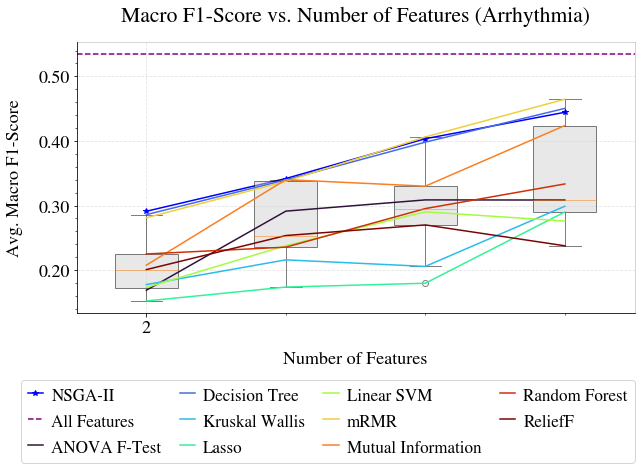

In [7]:
title = "Arrhythmia"
path = "Arrhythmia/sample_run/complete_evals_nsgaii_arrhythmia_10-gens_15-pop_5-k_2-to-10-feat_125-prob_xgb.csv"
agg_df, agg_df_non_processed, target_df = prepare_data(f"{base_results_dir}/{path}", target_clf="xgb", min_f=2, max_f=5)
plot_front_eval(title, agg_df, agg_df_non_processed, clf_name="XGBoost Classifier", display_mode = "both", path="figs")

 -- CuMiDa Leukemia -- 
ANOVA F-Test    &   0.6414 ($\pm$ 0.0067)  &   0.7759    &   0.2037 \\
Decision Tree    &   0.7574 ($\pm$ 0.0073)  &   0.7863    &   0.3364 \\
Kruskal Wallis    &   0.7177 ($\pm$ 0.0070)  &   0.8230    &   0.3421 \\
Lasso    &   0.7295 ($\pm$ 0.0080)  &   0.8796    &   0.2712 \\
Linear SVM    &   0.7439 ($\pm$ 0.0122)  &   0.8720    &   0.2253 \\
Mutual Information    &   0.7401 ($\pm$ 0.0075)  &   0.8027    &   0.3604 \\
\textbf{NSGA-II}    &   \textbf{0.8575 ($\pm$ 0.0099)}  &   \textbf{0.9333}    &   \textbf{0.4685} \\
Random Forest    &   0.6758 ($\pm$ 0.0411)  &   0.7807    &   0.2992 \\
ReliefF    &   0.7309 ($\pm$ 0.0063)  &   0.7766    &   0.3806 \\
mRMR    &   0.7109 ($\pm$ 0.0047)  &   0.7825    &   0.3211 \\
 
 -- CuMiDa Breast Cancer -- 
ANOVA F-Test    &   0.8873 ($\pm$ 0.0046)  &   0.9009    &   0.8657 \\
Decision Tree    &   0.8763 ($\pm$ 0.0080)  &   0.8853    &   0.8698 \\
Kruskal Wallis    &   0.8892 ($\pm$ 0.0041)  &   0.9096    &   0.8595 \\


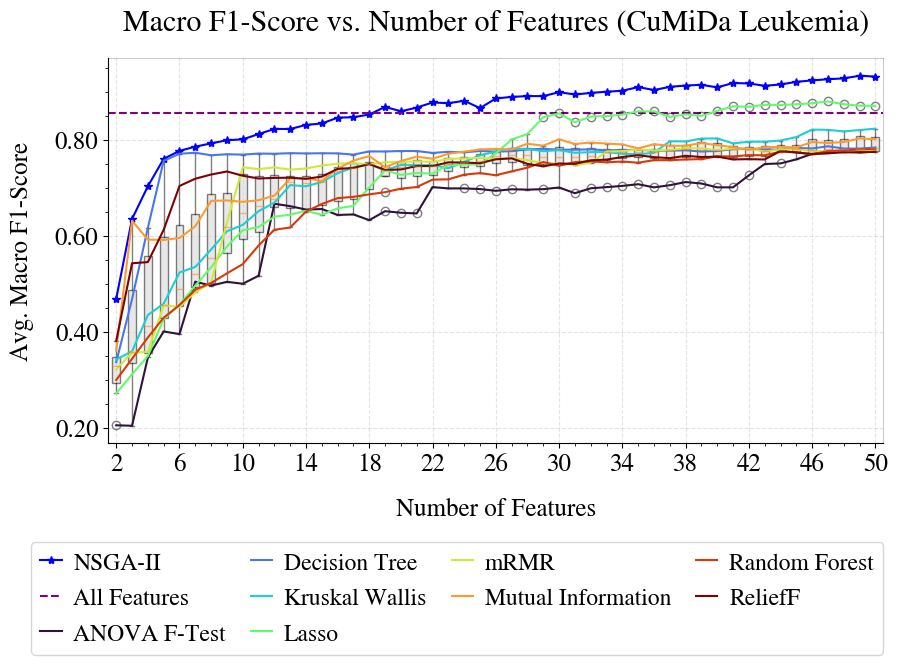

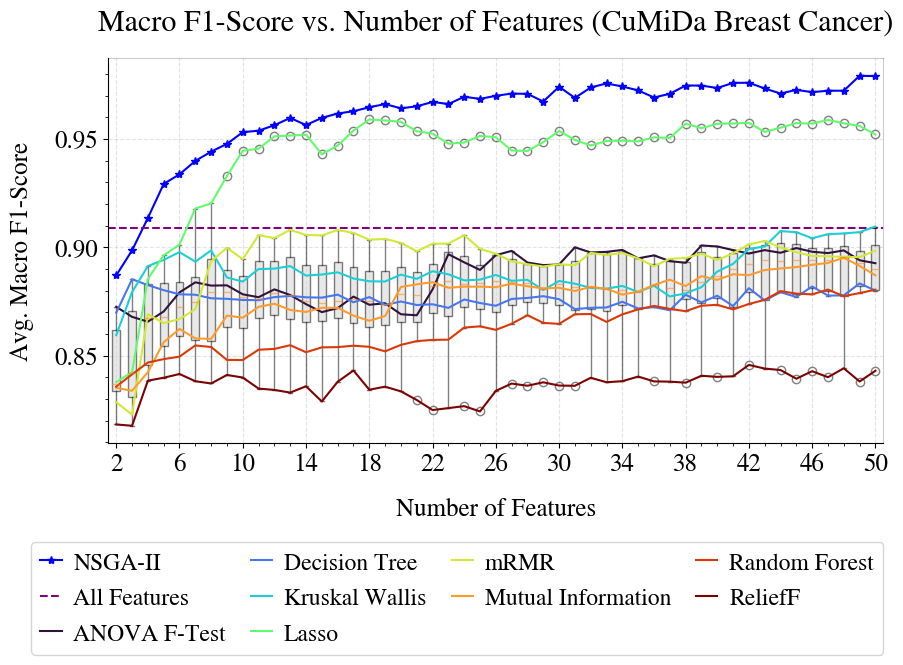

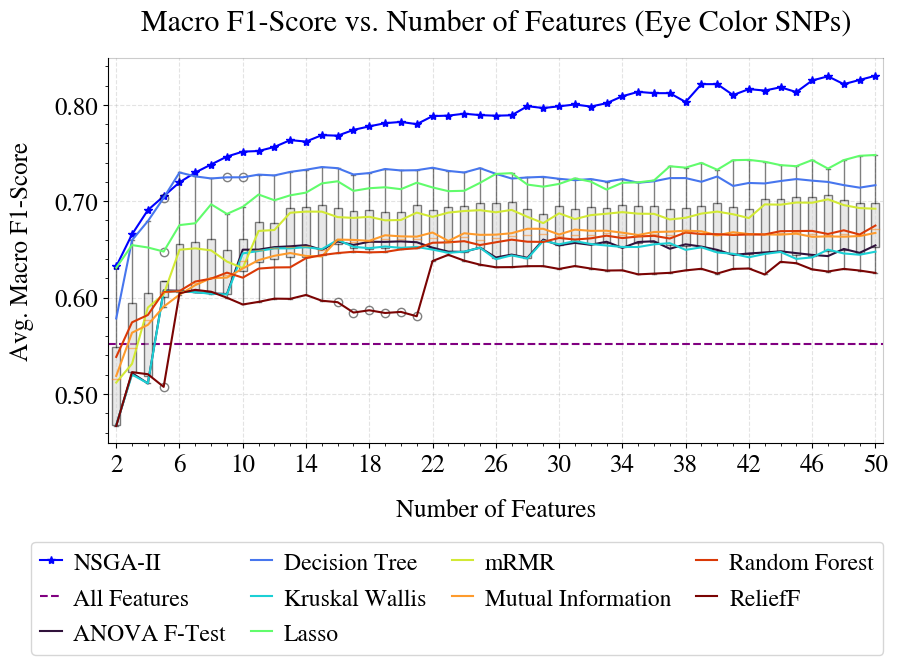

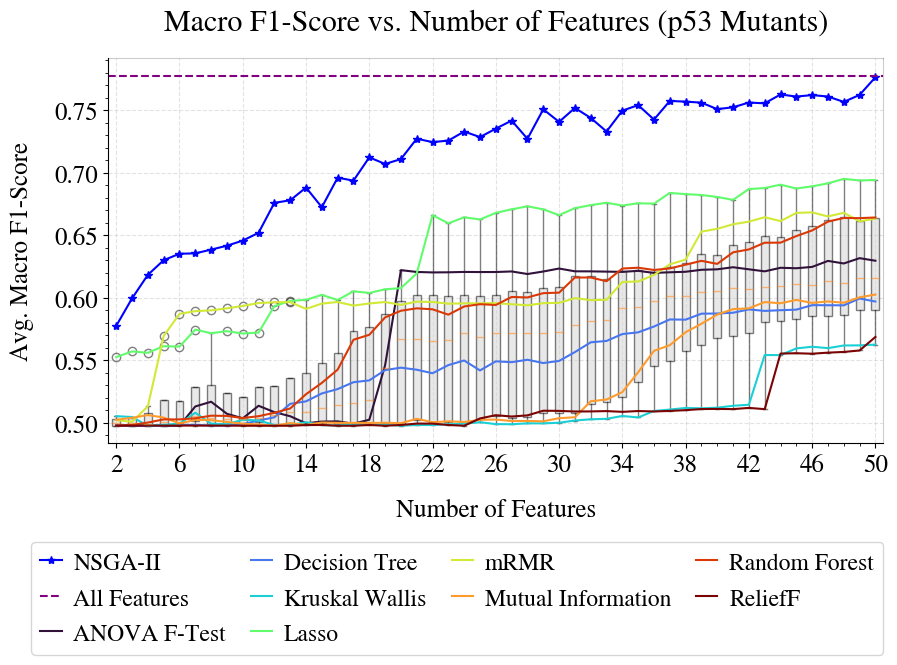

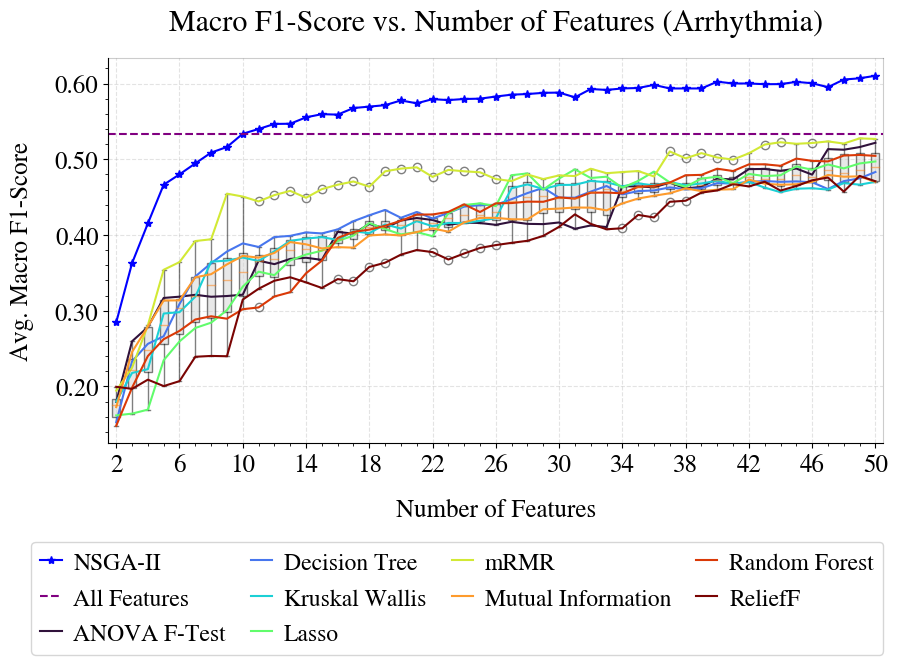

In [24]:
#dataset_paths = ['cec_corrected/front_assembled_extended_nsgaii_Breast_GSE70947_200-gens_200-pop_15-k_50-feat_125-prob_linearsvm_10-runs.csv',
#'cec_corrected/front_assembled_extended_nsgaii_Genes-Pigmentacao-63009-Eye-SemMissing-3-Classes_400-gens_200-pop_15-k_50-feat_125-prob_linearsvm_10-runs.csv',
#'cec_corrected/front_assembled_extended_nsgaii_p53_Mutants_200-gens_210-pop_15-k_50-feat_125-prob_linearsvm_10-runs.csv',
#'cec_corrected/front_assembled_extended_nsgaii_Leukemia_GSE28497_200-gens_200-pop_15-k_50-feat_125-prob_linearsvm_10-runs.csv',
#'cec_corrected/front_assembled_extended_nsgaii_arrhythmia_200-gens_210-pop_5-k_50-feat_125-prob_linearsvm_10-runs.csv']
#titles = ["CuMiDa Breast Cancer", "Eye Color SNPs", "p53 Mutants", "CuMiDa Leukemia", "Arrhythmia"]
#output_path = "../cec/figs/cec_corrected/"

dataset_paths = ["cec_shuffled/front_assembled_extended_nsgaii_Leukemia_GSE28497_200-gens_200-pop_15-k_50-feat_125-prob_linearsvm_10-runs.csv",
"cec_shuffled/front_assembled_extended_nsgaii_Breast_GSE70947_200-gens_200-pop_15-k_50-feat_125-prob_linearsvm_10-runs.csv",
"cec_shuffled/front_assembled_extended_nsgaii_Genes-Pigmentacao-63009-Eye-SemMissing-3-Classes_400-gens_200-pop_15-k_50-feat_125-prob_linearsvm_10-runs.csv", 
"cec_shuffled/front_assembled_extended_nsgaii_p53_Mutants_200-gens_200-pop_15-k_50-feat_125-prob_linearsvm_10-runs.csv", 
"cec_shuffled/front_assembled_extended_nsgaii_arrhythmia_200-gens_200-pop_5-k_50-feat_125-prob_linearsvm_10-runs.csv",
]
titles = ["CuMiDa Leukemia", "CuMiDa Breast Cancer", "Eye Color SNPs", "p53 Mutants", "Arrhythmia"]
output_path = "../cec/figs/cec_shuffled/"
avg_execution_times = []

for filename, title in zip(dataset_paths, titles):
    agg_df, agg_df_non_processed, target_df = prepare_data(f"{base_results_dir}/{filename}")
    plot_front_eval(title, agg_df, agg_df_non_processed, display_mode = "both", path=output_path)

    final_stats = (agg_df
                    .groupby(["experiment_id", "model", "fs_method"])["mean"]
                    .agg(["mean", "std", "max", "min"])
                    .reset_index()
                    .sort_values(["fs_method"]))

    final_stats_std = (agg_df
                    .groupby(["experiment_id", "model", "fs_method"])["std"]
                    .agg(["mean"])
                    .reset_index()
                    .sort_values(["fs_method"]))

    final_stats = final_stats.merge(final_stats_std, on=["experiment_id", "model", "fs_method"], how="left", suffixes=["", "_std"])
    final_stats = final_stats.sort_values("fs_method")

    best_perf_index = final_stats["mean"].idxmax()

    # Print performance summaries
    print(f""" -- {title} -- """ )
    for index, row in final_stats.iterrows():
        if index == best_perf_index:
            print(f"""\\textbf{{{row["fs_method"]}}}    &   \\textbf{{{row["mean"]:.4f} ($\pm$ {row["mean_std"]:.4f})}}  &   \\textbf{{{row["max"]:.4f}}}    &   \\textbf{{{row["min"]:.4f}}} \\\\""" )
        else:
            print(f"""{row["fs_method"]}    &   {row["mean"]:.4f} ($\pm$ {row["mean_std"]:.4f})  &   {row["max"]:.4f}    &   {row["min"]:.4f} \\\\""" )
    print(f""" """ )

    avg_execution_time = target_df[target_df["fs_method"].str.contains("NSGA")].groupby("run_id")["fit_time"].mean().mean()
    avg_execution_times.append((title, avg_execution_time))

print(f""" -- Average Execution times -- """ )

for i, row in enumerate(avg_execution_times):
    title, avg_execution_time = row
    print(f"""{title}   &   {datetime.timedelta(seconds=avg_execution_time)}    \\\\""")